In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os, random, re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import joblib
import warnings
warnings.filterwarnings("ignore")

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

In [ ]:
# Config
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/(( Internships Summer 2025 ))/Developers Hub/customer_support_tickets.csv"   # change if needed
TARGET_COL = "Ticket Type"
TEXT_COLUMNS_TO_COMBINE = ["Ticket Subject", "Ticket Description"]  # add more if exist
DROP_COLUMNS = [
    "Customer Name",
    "Customer Email",
    "Customer Age",
    "Customer Gender",
    "Resolution",
    "Customer Satisfaction Rating",
    "First Response Time",
    "Time to Resolution"
]
DO_TRANSFORMER = True   # set False if no GPU or want to skip heavy training
PALETTE = sns.color_palette("Set2")  # consistent color scheme

In [ ]:
print("Loading dataset...")
df = pd.read_csv(DATA_PATH, sep=None, engine="python")
print("Initial rows:", len(df))
print("Columns:", df.columns.tolist())

Loading dataset...
Initial rows: 8469
Columns: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']


In [ ]:
# Drop columns if present
cols_to_drop = [c for c in DROP_COLUMNS if c in df.columns]
df = df.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)
print("Remaining columns:", df.columns.tolist())

Dropped columns: ['Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Resolution', 'Customer Satisfaction Rating', 'First Response Time', 'Time to Resolution']
Remaining columns: ['Ticket ID', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Ticket Priority', 'Ticket Channel']


In [ ]:
# ---------- 2) Combine all text features into ticket_text ----------
for c in TEXT_COLUMNS_TO_COMBINE:
    if c not in df.columns:
        raise ValueError(f"Expected text column '{c}' not found in dataset.")

In [ ]:
# Create ticket_text by joining all available text columns (subject + description or more)
df["ticket_text"] = df[TEXT_COLUMNS_TO_COMBINE].fillna("").astype(str).agg(" ".join, axis=1)
print("Created 'ticket_text' (sample):")
print(df[["ticket_text"]].head(2))

Created 'ticket_text' (sample):
                                         ticket_text
0  Product setup I'm having an issue with the {pr...
1  Peripheral compatibility I'm having an issue w...


In [ ]:
# Keep a copy of target and meta (so target stays separate)
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Columns available: {df.columns.tolist()}")

In [ ]:
# ---------- 3) Cleaning text ----------
def clean_text_basic(txt):
    txt = str(txt).lower()
    txt = re.sub(r"http\S+|www\S+", " ", txt)
    txt = re.sub(r"[^a-z0-9\s]", " ", txt)   # keep alphanum and spaces
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

df["ticket_text_clean"] = df["ticket_text"].apply(clean_text_basic)
df["text_len"] = df["ticket_text_clean"].apply(len)
df["num_words"] = df["ticket_text_clean"].apply(lambda x: len(x.split()))

In [ ]:
# ---------- 4) Quick missing values & target distribution ----------
print("\nMissing values (top 15):")
print(df.isnull().sum().sort_values(ascending=False).head(15))

print("\n\nTarget distribution:")
print(df[TARGET_COL].value_counts())

# Drop rows with empty ticket_text after cleaning
df = df[df["ticket_text_clean"].str.strip() != ""].reset_index(drop=True)
print("\n\nRows after dropping empty texts:", len(df))


Missing values (top 15):
Ticket ID             0
Product Purchased     0
Date of Purchase      0
Ticket Type           0
Ticket Subject        0
Ticket Description    0
Ticket Status         0
Ticket Priority       0
Ticket Channel        0
ticket_text           0
ticket_text_clean     0
text_len              0
num_words             0
dtype: int64


Target distribution:
Ticket Type
Refund request          1752
Technical issue         1747
Cancellation request    1695
Product inquiry         1641
Billing inquiry         1634
Name: count, dtype: int64


Rows after dropping empty texts: 8469


In [ ]:
# If extremely rare labels exist, drop
MIN_CLASS_SIZE = 5
label_counts = df[TARGET_COL].value_counts()
valid_labels = label_counts[label_counts >= MIN_CLASS_SIZE].index.tolist()
df = df[df[TARGET_COL].isin(valid_labels)].reset_index(drop=True)
print("Labels kept:", len(valid_labels), valid_labels)

Labels kept: 5 ['Refund request', 'Technical issue', 'Cancellation request', 'Product inquiry', 'Billing inquiry']


## **VISUALIZATION**

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,4)

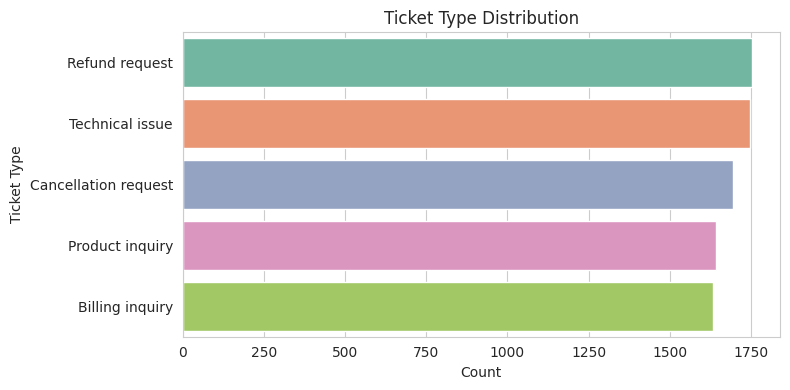

In [ ]:
# Target distribution (horizontal bar)
plt.figure()
order = df[TARGET_COL].value_counts().index
sns.countplot(y=TARGET_COL, data=df, order=order, palette=PALETTE)
plt.title("Ticket Type Distribution")
plt.xlabel("Count")
plt.ylabel("Ticket Type")
plt.tight_layout()
plt.show()

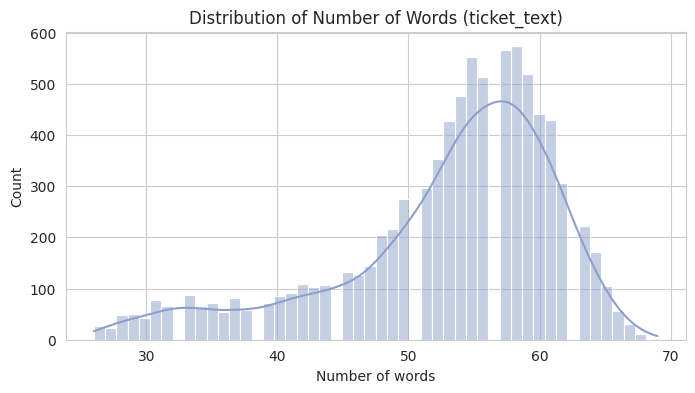

In [ ]:
# Words and length distributions
plt.figure()
sns.histplot(df["num_words"], bins=50, kde=True, color=PALETTE[2])
plt.title("Distribution of Number of Words (ticket_text)")
plt.xlabel("Number of words")
plt.show()

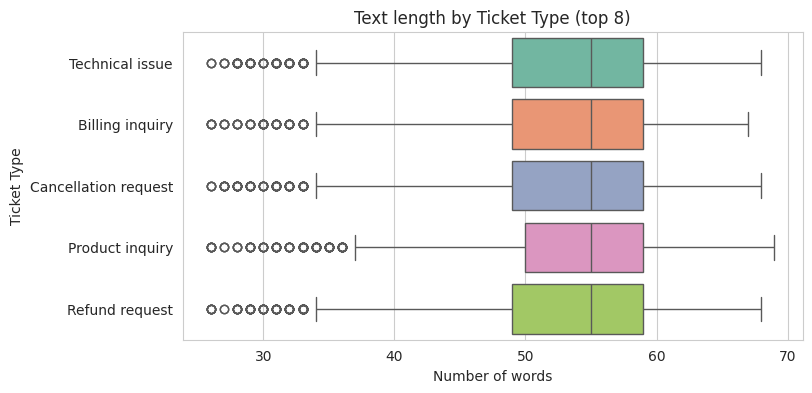

In [ ]:
plt.figure()
sns.boxplot(x="num_words", y=TARGET_COL, data=df[df[TARGET_COL].isin(order[:8])], palette=PALETTE)
plt.title("Text length by Ticket Type (top 8)")
plt.xlabel("Number of words")
plt.show()

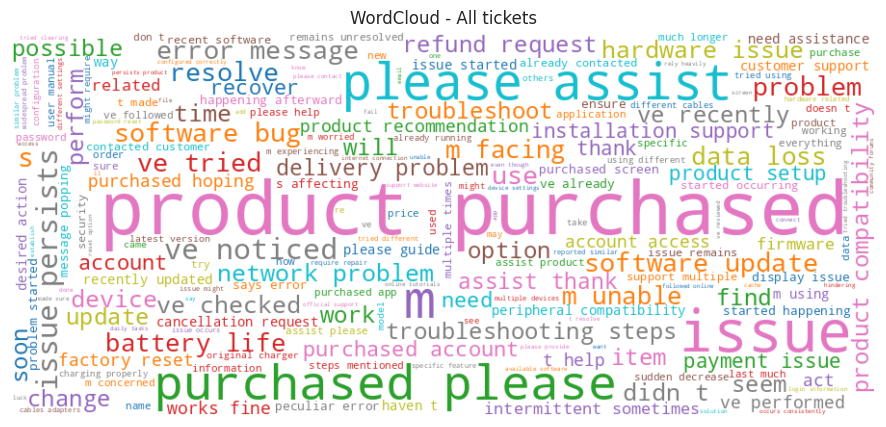

In [ ]:
# WordCloud overall
all_text = " ".join(df["ticket_text_clean"].tolist())
wc = WordCloud(width=900, height=400, background_color="white", colormap="tab10").generate(all_text)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - All tickets")
plt.show()

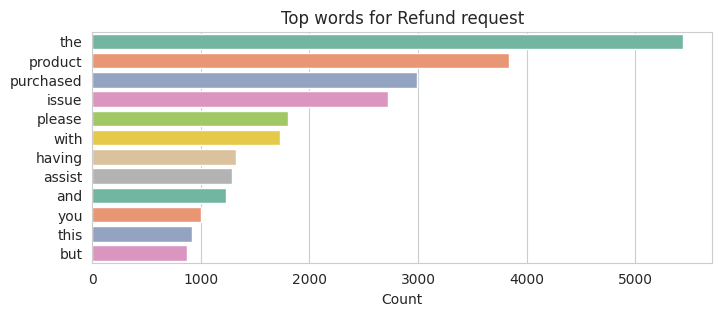

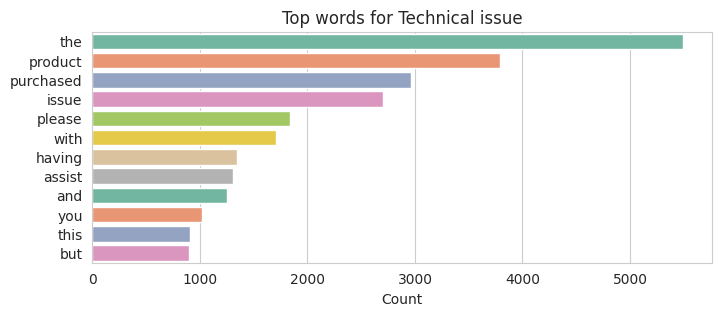

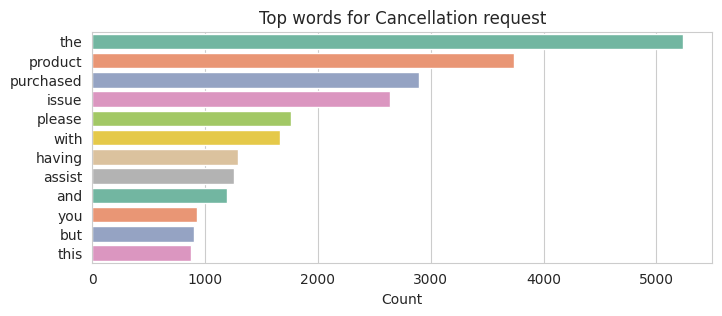

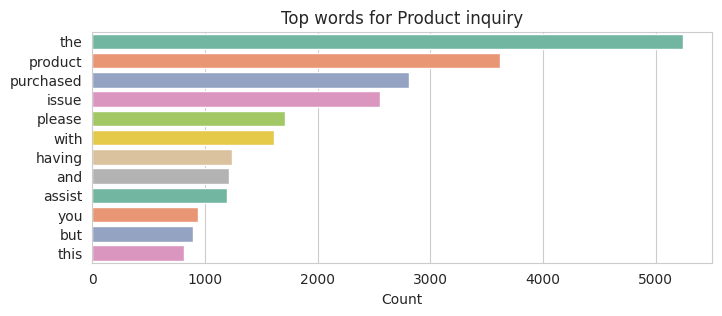

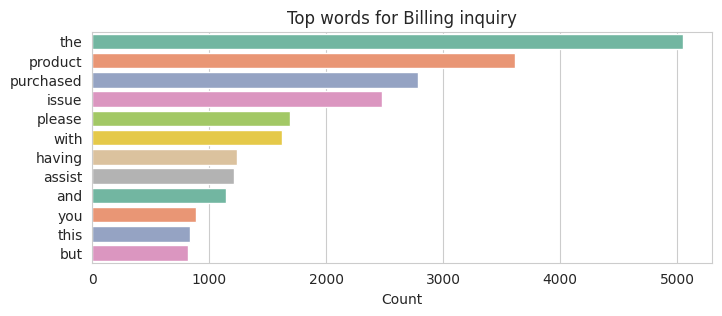

In [ ]:
# Top words per top 5 labels
top_labels = df[TARGET_COL].value_counts().nlargest(5).index.tolist()
for label in top_labels:
    txt = " ".join(df[df[TARGET_COL] == label]["ticket_text_clean"].tolist())
    words = [w for w in txt.split() if len(w) > 2]
    common = Counter(words).most_common(12)
    if not common:
        continue
    words_list, freq = zip(*common)
    plt.figure(figsize=(8,3))
    sns.barplot(x=list(freq), y=list(words_list), palette=PALETTE)
    plt.title(f"Top words for {label}")
    plt.xlabel("Count")
    plt.show()

### **TRAIN/TEST**

In [ ]:
# ---------- Prepare train/test ----------
X = df["ticket_text_clean"]
y = df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 6775, Test: 1694


# **SIMPLE APPROACH**

### **Baseline: TF-IDF + LogisticRegression**

In [ ]:
print("\n--- Baseline: TF-IDF + LogisticRegression ---")
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

clf_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_SEED)
clf_lr.fit(X_train_tfidf, y_train)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print('\n\nACCURACY OF SIMPLE APPROACH - LOGISTIC REGRESSION')
print("\n\nAccuracy (LR):", accuracy_score(y_test, y_pred_lr))
print("\nF1 macro (LR):", f1_score(y_test, y_pred_lr, average="macro"))
print("\nClassification report (LR):\n", classification_report(y_test, y_pred_lr))


--- Baseline: TF-IDF + LogisticRegression ---


ACCURACY OF SIMPLE APPROACH - LOGISTIC REGRESSION


Accuracy (LR): 0.21605667060212513

F1 macro (LR): 0.2161147888331052

Classification report (LR):
                       precision    recall  f1-score   support

     Billing inquiry       0.19      0.22      0.20       327
Cancellation request       0.23      0.21      0.22       339
     Product inquiry       0.23      0.25      0.24       328
      Refund request       0.20      0.19      0.20       351
     Technical issue       0.23      0.21      0.22       349

            accuracy                           0.22      1694
           macro avg       0.22      0.22      0.22      1694
        weighted avg       0.22      0.22      0.22      1694



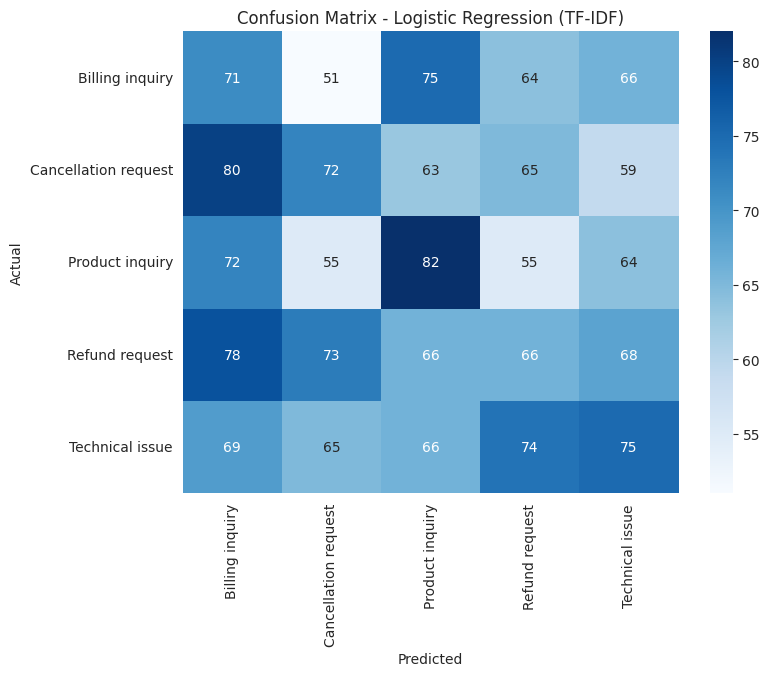

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=clf_lr.classes_, yticklabels=clf_lr.classes_, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Save baseline
os.makedirs("artifacts", exist_ok=True)
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")
joblib.dump(clf_lr, "artifacts/logreg_tfidf.joblib")
print("Saved TF-IDF and LogisticRegression to artifacts/")

Saved TF-IDF and LogisticRegression to artifacts/


# **LLMS APPROACH - DistilBERT**

In [ ]:
#pip install --upgrade transformers datasets --quiet

In [ ]:
#pip install --upgrade tokenizers huggingface-hub --quiet

In [ ]:
#pip install --upgrade datasets

In [ ]:
#!pip install transformers datasets torch

In [ ]:
import os, numpy as np, torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Safety checks: use existing X_train, X_test, y_train, y_test
try:
    X_train
    X_test
    y_train
    y_test
except NameError:
    raise RuntimeError("X_train/X_test/y_train/y_test not found. Run train_test_split first.")

In [ ]:
print("Preparing DistilBERT datasets...")

# Map labels -> ids using the training+test labels (keeps consistent ordering)
labels = sorted(pd.Index(y_train).append(pd.Index(y_test)).unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
print("Labels:", label2id)

Preparing DistilBERT datasets...
Labels: {'Billing inquiry': 0, 'Cancellation request': 1, 'Product inquiry': 2, 'Refund request': 3, 'Technical issue': 4}


In [ ]:
# Build small HF datasets from pandas series
df_train = pd.DataFrame({"text": X_train.values, "label": [label2id[l] for l in y_train.values]})
df_test  = pd.DataFrame({"text": X_test.values,  "label": [label2id[l] for l in y_test.values]})

ds_train = Dataset.from_pandas(df_train)
ds_test  = Dataset.from_pandas(df_test)

In [ ]:
# Tokenizer & preprocessing
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

ds_train = ds_train.map(preprocess_fn, batched=True)
ds_test  = ds_test.map(preprocess_fn, batched=True)

# Keep only columns Trainer needs
keep_cols = ["input_ids", "attention_mask", "label"]
cols_to_remove = [c for c in ds_train.column_names if c not in keep_cols]
if cols_to_remove:
    ds_train = ds_train.remove_columns(cols_to_remove)
    ds_test  = ds_test.remove_columns(cols_to_remove)

ds_train.set_format("torch")
ds_test.set_format("torch")

Map:   0%|          | 0/6775 [00:00<?, ? examples/s]

Map:   0%|          | 0/1694 [00:00<?, ? examples/s]

In [ ]:
# Load model (classifier head will be randomly init and trained)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Device info
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [ ]:
#pip install --upgrade transformers

In [ ]:
import transformers
print(transformers.__version__)

4.56.0


In [ ]:
from transformers import TrainingArguments
print("evaluation_strategy" in TrainingArguments.__init__.__code__.co_varnames)
print(TrainingArguments.__init__.__code__.co_varnames)

False
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_bac

In [ ]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# TrainingArguments tuned for CPU (if GPU available, it will use it)
training_args = TrainingArguments(
    output_dir="./trainer_results_cpu",
    num_train_epochs=1,   # <--- start with 1, bump to 2-3 if you can
    per_device_train_batch_size=8 if device=="cuda" else 4,
    per_device_eval_batch_size=16 if device=="cuda" else 8,
    gradient_accumulation_steps=1 if device=="cuda" else 2,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="epoch",
    load_best_model_at_end=False,  # keep False for CPU to avoid extra I/O; set True later if desired
    logging_steps=20,
    report_to=[],                  # disable external loggers
    fp16=(device=="cuda"),
    seed=RANDOM_SEED
)

In [ ]:
# Compute metrics function used by Trainer (will run during evaluation)
def compute_metrics_eval(eval_pred):
    logits, labels_ids = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels_ids, preds),
        "f1_macro": f1_score(labels_ids, preds, average="macro"),
        "precision_macro": precision_score(labels_ids, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels_ids, preds, average="macro", zero_division=0)
    }

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
# Train (this will print progress)
print("\nStarting DistilBERT training (this can take minutes on CPU)…")
train_result = trainer.train()
print("Training completed. Checkpoint saved to:", training_args.output_dir)

# Save model & tokenizer
os.makedirs("artifacts/distilbert_ticket_model_cpu", exist_ok=True)
trainer.save_model("artifacts/distilbert_ticket_model_cpu")
tokenizer.save_pretrained("artifacts/distilbert_ticket_model_cpu")
print("Saved DistilBERT model & tokenizer to artifacts/distilbert_ticket_model_cpu")

# --- Quick evaluation & detailed report ---
print("\nEvaluating on test set...")
eval_metrics = trainer.evaluate(ds_test)
print("Eval metrics:", eval_metrics)


Starting DistilBERT training (this can take minutes on CPU)…


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
20,1.613800,1.624374,0.194215,0.105924,0.077340,0.187788
40,1.631900,1.619057,0.208973,0.078221,0.108058,0.201891
60,1.605300,1.638934,0.193625,0.064886,0.038725,0.200000
80,1.633900,1.624775,0.200708,0.072282,0.095532,0.200689
100,1.614100,1.626557,0.193034,0.064720,0.038607,0.200000
120,1.619600,1.614616,0.193034,0.064720,0.038607,0.200000
140,1.605300,1.616292,0.207792,0.088032,0.090036,0.201014
160,1.617200,1.612915,0.208383,0.122709,0.140278,0.203250
180,1.634600,1.615187,0.194215,0.067141,0.118721,0.201146
200,1.610400,1.615941,0.193625,0.064886,0.038725,0.200000


Training completed. Checkpoint saved to: ./trainer_results_cpu
Saved DistilBERT model & tokenizer to artifacts/distilbert_ticket_model_cpu

Evaluating on test set...


Eval metrics: {'eval_loss': 1.6090749502182007, 'eval_accuracy': 0.20720188902007083, 'eval_f1_macro': 0.06865525672371639, 'eval_precision_macro': 0.04144037780401417, 'eval_recall_macro': 0.2, 'eval_runtime': 329.4349, 'eval_samples_per_second': 5.142, 'eval_steps_per_second': 0.644, 'epoch': 1.0}


In [ ]:
# Get predictions (for detailed classification report + confusion matrix)
preds_out = trainer.predict(ds_test)
pred_ids = np.argmax(preds_out.predictions, axis=1)
y_true_ids = np.array(ds_test["label"])
y_true = [id2label[i] for i in y_true_ids]
y_pred = [id2label[i] for i in pred_ids]

print("\nClassification report (DistilBERT):\n")
print(classification_report(y_true, y_pred, zero_division=0))


Classification report (DistilBERT):

                      precision    recall  f1-score   support

     Billing inquiry       0.00      0.00      0.00       327
Cancellation request       0.00      0.00      0.00       339
     Product inquiry       0.00      0.00      0.00       328
      Refund request       0.21      1.00      0.34       351
     Technical issue       0.00      0.00      0.00       349

            accuracy                           0.21      1694
           macro avg       0.04      0.20      0.07      1694
        weighted avg       0.04      0.21      0.07      1694



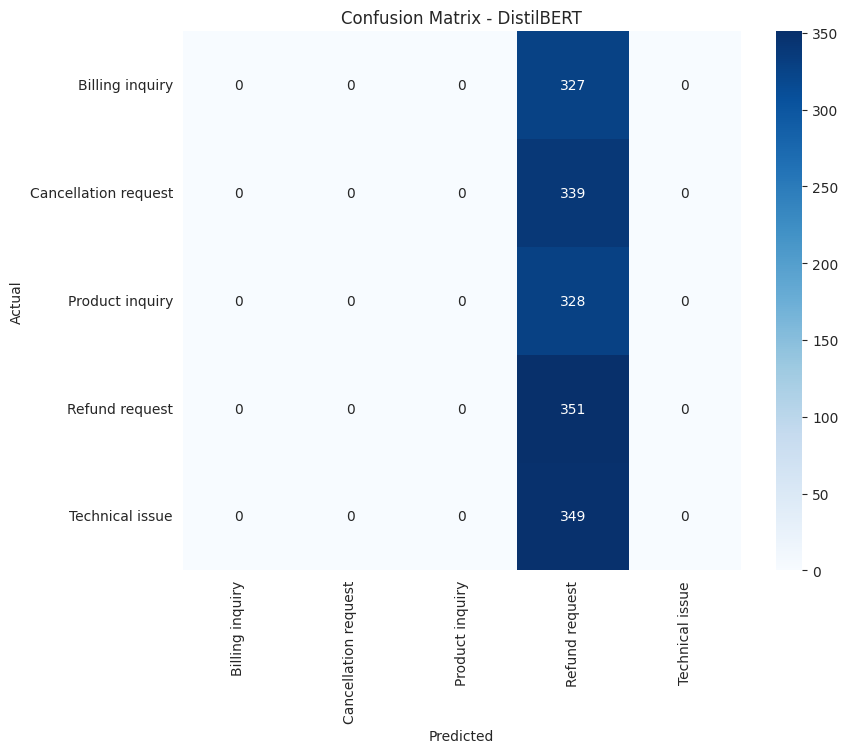

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Small inference helper using saved model (single / batch)
def predict_distilbert_single(subject, description, top_k=3):
    txt = (str(subject or "") + " " + str(description or ""))
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    top_idx = np.argsort(probs)[::-1][:top_k]
    return {id2label[i]: float(probs[i]) for i in top_idx}

def predict_distilbert_batch(list_of_texts, top_k=3):
    results = []
    for txt in list_of_texts:
        subject = txt.get("subject","")
        description = txt.get("description","")
        results.append(predict_distilbert_single(subject, description, top_k=top_k))
    return results

print("\nExample inference (single):")
print(predict_distilbert_single("Refund for wrong product", "I received the wrong item and want a refund."))


Example inference (single):
{'Refund request': 0.23096619546413422, 'Billing inquiry': 0.20324170589447021, 'Cancellation request': 0.19255119562149048}
